## Amazon Fine Foods Sentiment Analysis Python Project

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [139]:
df = pd.read_csv('../project_4/Reviews.csv')
df = df.head(10000)

In [140]:
df.shape

(10000, 10)

### Quick EDA

<Axes: title={'center': 'Count of Reviews by Stars'}, xlabel='Review Stars'>

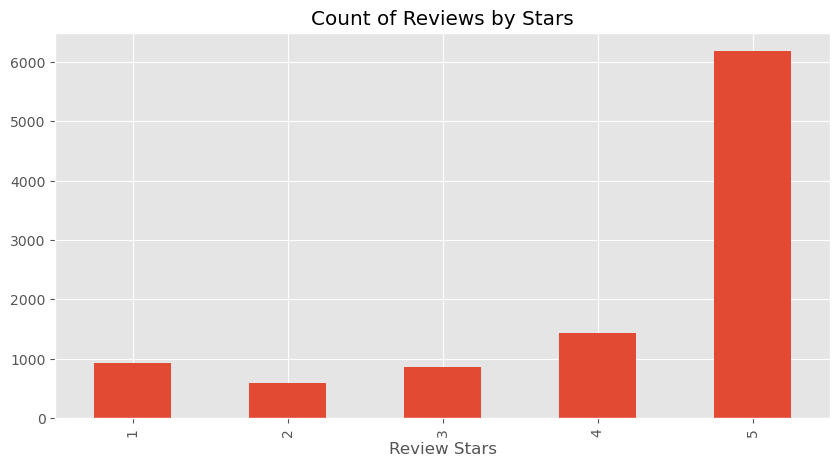

In [141]:
df['Score'].value_counts().sort_index().plot(kind = 'bar', xlabel = 'Review Stars', title = 'Count of Reviews by Stars', figsize = (10, 5))

### Basic NLTK

In [33]:
sample = df['Text'][50]
print(sample)

df.shape

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


(500, 10)

In [36]:
tokens = nltk.word_tokenize(sample)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [41]:
tagged = nltk.pos_tag(tokens)
tagged[:10]


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

### Using VADER for Sentiment Scoring
NLTK module that provides sentiment scores based on the words used

to get the negative/nuetral/positive scores of the given text(review)

- Uses "bag of words" approach
    1. stop words are removed (words that have not neg/nue/positve feedback)
    2. each word is scored and combined to a total score

In [142]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [145]:
# testing scores

sia.polarity_scores('I sampled the I had the chance to sample the Chilli Garlic from Amazon, and I must say, I was not impressed. The flavors were bland and lacked any excitement. The texture was off-putting, with a strange aftertaste that lingered. I had high hopes, but unfortunately, this product fell short of my expectations. I won|\'t be considering a purchase in the future. from Amazon, and I\'m quite impressed. The flavors were unexpectedly delightful, and the texture was just right. It\'s definitely worth trying out!')

{'neg': 0.102, 'neu': 0.682, 'pos': 0.216, 'compound': 0.8652}

In [60]:
sia.polarity_scores(sample)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [146]:
sia.polarity_scores('I had the chance to sample the Ms. Cookies from Amazon, and I must say, \
                    I was not impressed. The flavors were bland and lacked any excitement. The texture was off-putting, with \
                    a strange aftertaste that lingered. I had high hopes, but unfortunately, this product fell short of my expectations. \
                    I won\'t be considering a purchase in the future. from Amazon, and I must say, I was not impressed. The flavors were \
                    bland and lacked any excitement. The texture was off-putting, with a strange aftertaste that lingered. I had high hopes, \
                    but unfortunately, this product fell short of my expectations. I won\'t be considering a purchase in the future.')

{'neg': 0.13, 'neu': 0.723, 'pos': 0.147, 'compound': 0.2481}

<div class="alert alert-block alert-danger">
    <p style = "font-size: 15px;">The compound score is 0.3595, which is a positive value. This suggests that VADER's sentiment analysis perceives the review as leaning slightly towards being positive, despite the content of the review being negative. It might not accurately capture the negative sentiment expressed in the review since the compound score indicates a more positive sentiment than what is actually present in the text. This showcases a limitation of sentiment analysis tools like VADER, as they might not always fully understand the nuanced emotions and contexts in text.</p>  
</div>



In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    id = row['Id']
    res[id] = sia.polarity_scores(text)

In [148]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df, how='left')

vaders.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Plot VADER Results

VADER results from 568,454 reviews

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

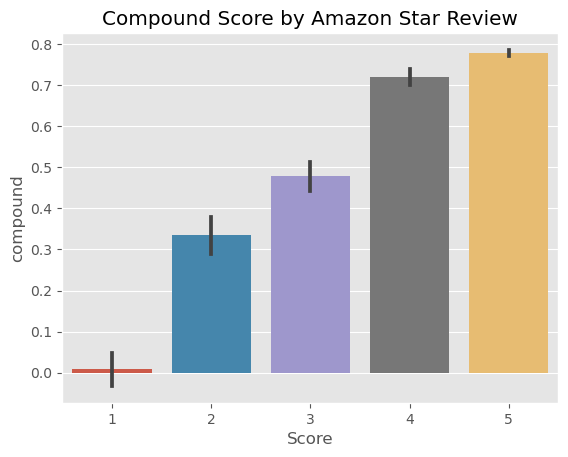

In [149]:
vis1 = sns.barplot(data = vaders, x = 'Score', y = 'compound')
vis1.set_title('Compound Score by Amazon Star Review')

<div class="alert alert-block alert-success">
    <p style = "font-size: 15px;">The visualization illustrates the correlation between sentiment and Amazon star ratings. It's apparent that 1-star reviews tend to have lower or even negative compound sentiment scores, indicating a more negative sentiment. Conversely, 5-star reviews show higher compound sentiment scores, reflecting a more positive sentiment. This visualization visually reinforces the trend that lower ratings are associated with negative sentiments, while higher ratings are associated with positive sentiments in the reviews.</p>
</div>

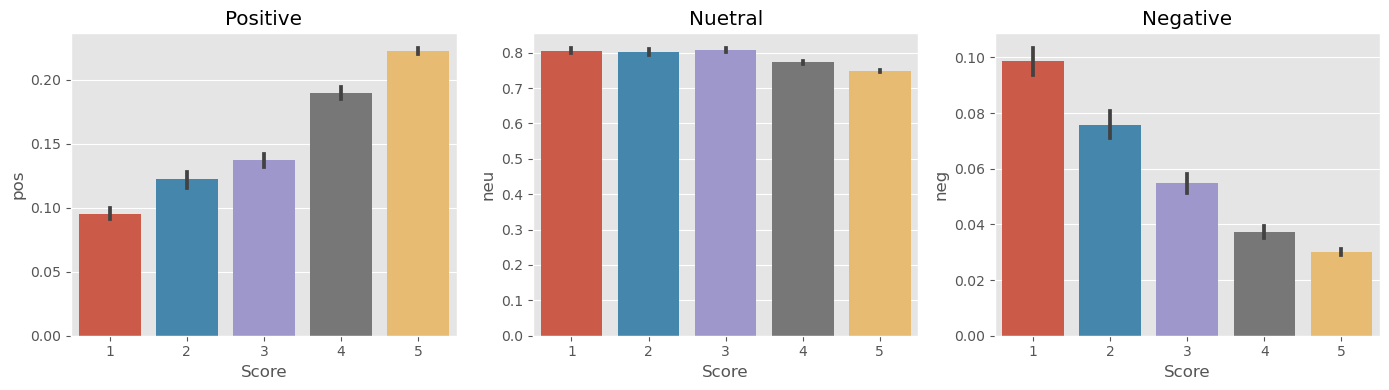

In [150]:
fig, axs = plt.subplots(1, 3, figsize = (14,4))

sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data= vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data= vaders, x = 'Score', y = 'neg', ax = axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Nuetral')
axs[2].set_title('Negative')

plt.tight_layout()

<div class="alert alert-block alert-success">
    <p style = "font-size: 15px;">This demonstrates how customers' sentiment aligns with their star ratings. For instance, if the 5-star category has the tallest yellow bar, it suggests that customers who rate the product highly are more likely to express positive sentiments.</p>
</div>

### Using RoBERTa Pretained Model

- Utilizing RoBERTa, allowing us to capture intricate contextual nuances in language. It can better understand the relationships between words and phrases, which is essential for accurately gauging sentiment.


In [151]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [152]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [153]:
sample = 'I had the chance to sample the Ms. Cookies from Amazon, and I must say, \
            I was not impressed. The flavors were bland and lacked any excitement. The texture was off-putting, with \
            a strange aftertaste that lingered. I had high hopes, but unfortunately, this product fell short of my expectations. \
            I won\'t be considering a purchase in the future. from Amazon, and I must say, I was not impressed. The flavors were \
            bland and lacked any excitement. The texture was off-putting, with a strange aftertaste that lingered. I had high hopes, \
            but unfortunately, this product fell short of my expectations. I won\'t be considering a purchase in the future.'

In [154]:
encoded_text = tokenizer(sample, return_tensors = 'pt') # For the model to understand the text
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9342782, 'roberta_neu': 0.05709272, 'roberta_pos': 0.008629131}


In [155]:
def polarity_scores_roberta(sample):
    encoded_text = tokenizer(sample, return_tensors = 'pt') # For the model to understand the text
    
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [156]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        id = row['Id']
        vader_result = sia.polarity_scores(text)

        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f"Broke for id {id}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583
Broke for id 5040
Broke for id 5182
Broke for id 5192
Broke for id 5365
Broke for id 5442
Broke for id 5709
Broke for id 5998
Broke for id 6003
Broke for id 6007
Broke for id 6106
Broke for id 6234
Broke for id 6558

In [157]:
output_df = pd.DataFrame(res).T
output_df = output_df.reset_index().rename(columns = {'index':'Id'})
output_df = output_df.merge(df, how='left')
output_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [158]:
test_roberta = output_df[['roberta_neg', 'roberta_neu', 'roberta_pos']]
test_roberta

,roberta_neg,roberta_neu,roberta_pos
0,0.009624,0.049980,0.940395
1,0.508986,0.452414,0.038600
2,0.003229,0.098067,0.898704
3,0.002295,0.090219,0.907486
4,0.001635,0.010302,0.988063
...,...,...,...
9912,0.339595,0.407847,0.252558
9913,0.010780,0.110858,0.878362
9914,0.036277,0.215930,0.747794
9915,0.011023,0.043542,0.945435


In [159]:
conditions = [
    (output_df['roberta_pos'] > output_df['roberta_neg']) & (output_df['roberta_pos'] > output_df['roberta_neu']),
    (output_df['roberta_neg'] > output_df['roberta_pos']) & (output_df['roberta_neg'] > output_df['roberta_neu']),
    (output_df['roberta_neu'] > output_df['roberta_pos']) & (output_df['roberta_neu'] > output_df['roberta_neg'])
]

values = ['positive', 'negative', 'neutral']

output_df['roberta_overall_sentiment'] = np.select(conditions, values)

output_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,roberta_overall_sentiment
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive


In [161]:
output_df['roberta_overall_sentiment'].value_counts()

positive    7674
negative    1571
neutral      672
Name: roberta_overall_sentiment, dtype: int64

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='Reviews'>

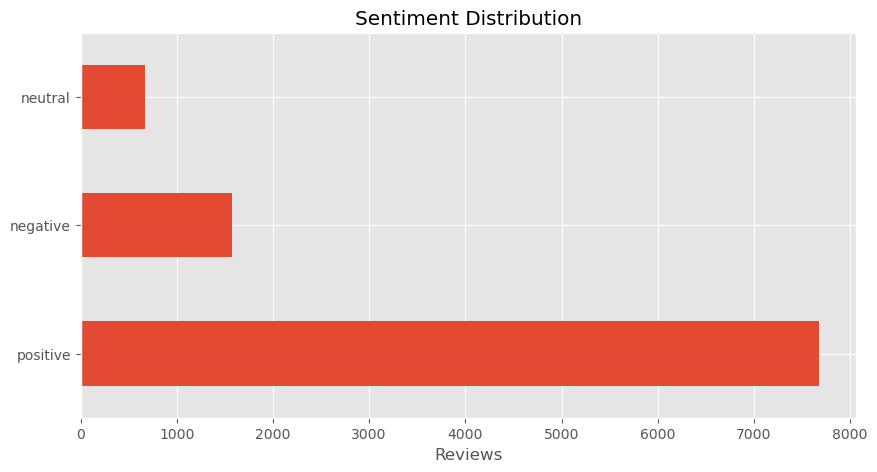

In [160]:
output_df['roberta_overall_sentiment'].value_counts().plot(kind = 'barh', xlabel = 'Reviews', title = 'Sentiment Distribution', figsize = (10, 5))

<div class="alert alert-block alert-success">
    <p style = "font-size: 15px;">
        The fact that there are significantly more positive reviews (7674) than negative (1571) and neutral (672) ones suggests that, overall, customers tend to have a positive sentiment towards these food products. This could be an indication of customer satisfaction.
    </p>
</div>

## Comparing and Combining Scores between Models

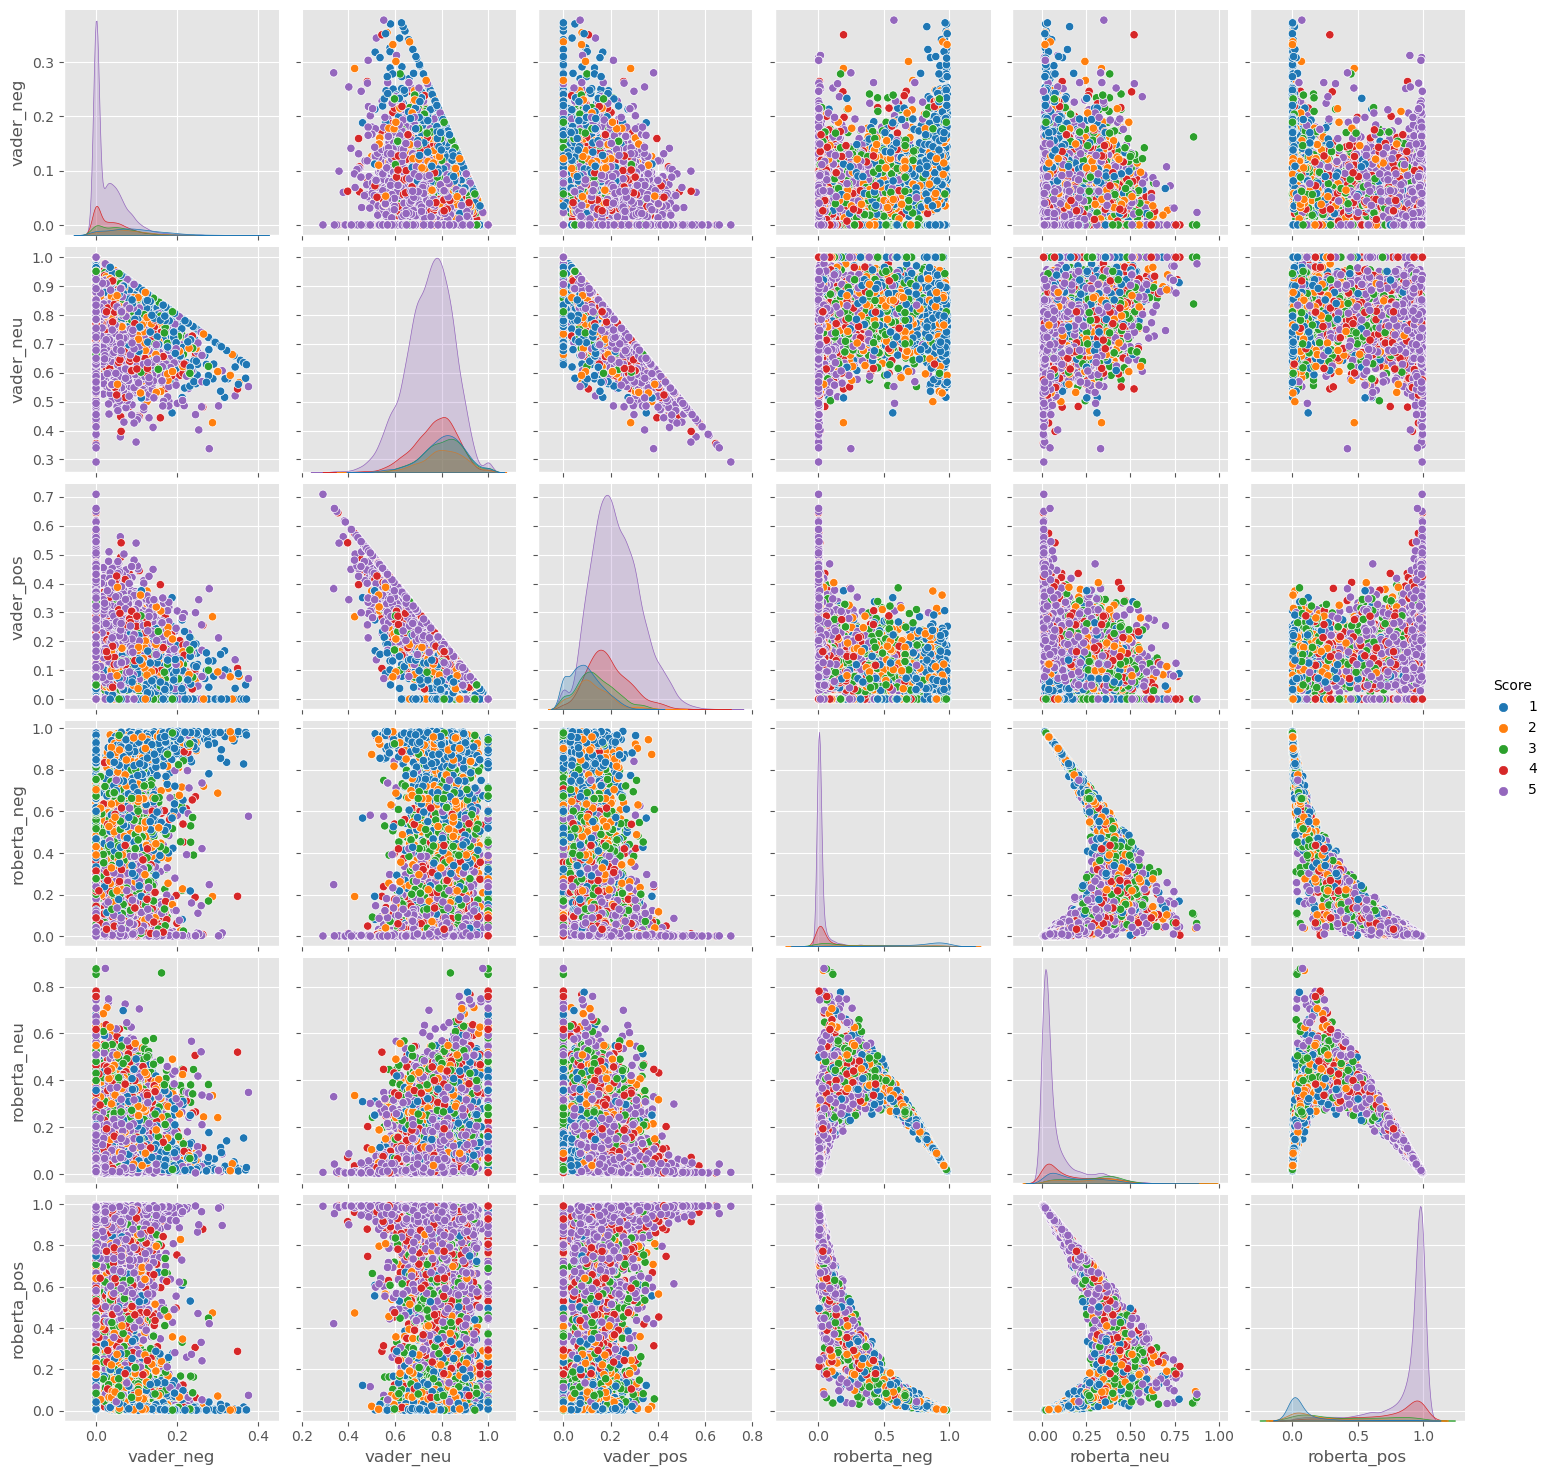

In [162]:
sns.pairplot(data = output_df, vars = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue = 'Score', palette = 'tab10')

<div class="alert alert-block alert-success">
    <p style = "font-size: 15px;">Utilizing two distinct approaches, VADER and the RoBERTa Pretrained Model, our analysis reveals that RoBERTa consistently provides more precise sentiment scores for each review, capturing the subtle nuances and context within the text. The visualization demonstrates this by showcasing the divergence in sentiment scores assigned by the two models for each review.
    </p>
</div>

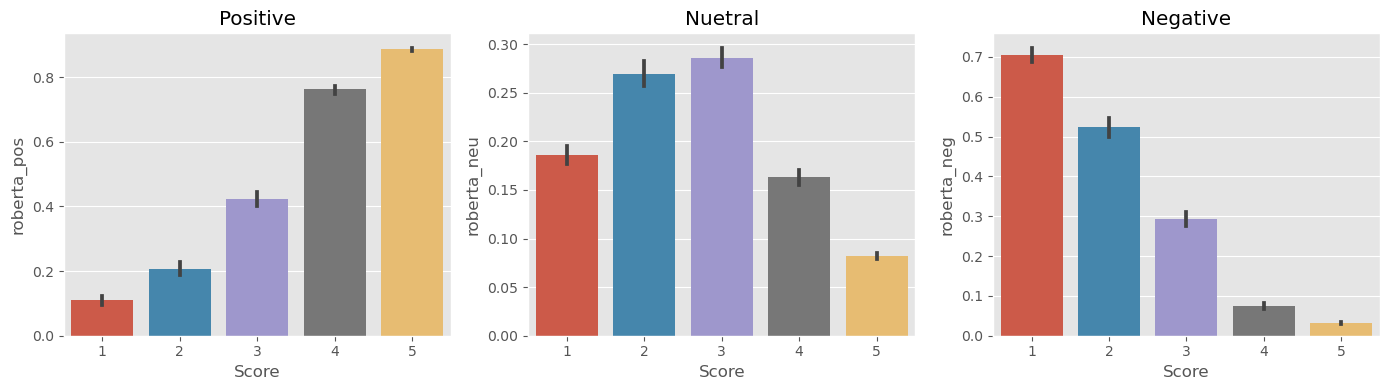

In [163]:
fig, axs = plt.subplots(1, 3, figsize = (14,4))

sns.barplot(data = output_df, x = 'Score', y = 'roberta_pos', ax = axs[0])
sns.barplot(data= output_df, x = 'Score', y = 'roberta_neu', ax = axs[1])
sns.barplot(data= output_df, x = 'Score', y = 'roberta_neg', ax = axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Nuetral')
axs[2].set_title('Negative')

plt.tight_layout()

<div class="alert alert-block alert-success">
    <p style = "font-size: 15px;">Once more, this demonstrates how customers' sentiment aligns with their star ratings. For instance, if the 5-star category has the tallest yellow bar, it suggests that customers who rate the product highly are more likely to express positive sentiments.
    RoBERTa offers a more nuanced breakdown of sentiment into positive, neutral, and negative categories, allowing for a deeper understanding of the sentiment distribution within each star rating. Rather than VADER which is simpler and rule-based, making it easier to implement but potentially less accurate in capturing nuanced sentiment.
    </p>
</div>

## Exploring More Examples

- 1 star positive review
- 5 star negative review

In [98]:
output_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [99]:
output_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [100]:
output_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [101]:
output_df.query('Score == 5').sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Testing Transformers Pipeline

In [ ]:
from transformers import pipeline

pipeline = pipeline('sentiment-analysis')

In [105]:
pipeline('I had the chance to sample the Ms. Cookies from Amazon, and I must say, \
            I was not impressed. The flavors were bland and lacked any excitement. The texture was off-putting, with \
            a strange aftertaste that lingered. I had high hopes, but unfortunately, this product fell short of my expectations. \
            I won\'t be considering a purchase in the future. from Amazon, and I must say, I was not impressed. The flavors were \
            bland and lacked any excitement. The texture was off-putting, with a strange aftertaste that lingered. I had high hopes, \
            but unfortunately, this product fell short of my expectations. I won\'t be considering a purchase in the future.')

[{'label': 'NEGATIVE', 'score': 0.9997215867042542}]

In [106]:
pipeline('So we cancelled the order.  It was cancelled without any problem.  That is a positive note...')

[{'label': 'POSITIVE', 'score': 0.9988051652908325}]

In [107]:
pipeline('this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault')

[{'label': 'NEGATIVE', 'score': 0.9980344176292419}]